In [1]:
import os
import pickle

import numpy as np
from matplotlib import pyplot as plt

In [2]:
class DataFrame:

    def __init__(self, *keys):
        self._keys = keys
        self._data = []

    def _select(self, **keywords):
        if (result := set(keywords.keys()) - set(self._keys)) != set():
            raise KeyError(f"Invalid keys {result}. Keys must be in {set(self._keys)}.")

        out = []
        for keys, data in self._data:
            select = True
            for key, value in keywords.items():
                if keys[key] != value:
                    select = False
                    break
            if select:
                out.append(data)

        return out

    def __call__(self, **keywords):
        return self._select(**keywords)

    def add(self, data, **keyword):
        if set(keyword.keys()) != set(self._keys):
            raise KeyError(f"Keys must match {set(self._keys)}.")

        d = dict.fromkeys(self._keys)
        for key, value in keyword.items():
            d[key] = value

        self._data.append((d, data))

In [3]:
def load_sol(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)


def extract_keys(filename):
    filename = filename.split("-")

    if filename[0] == "objective":
        type_, var, phase, case, weight, iter_ = filename[:6]
        case = int(case)
        if weight == "1000.0":
            weight = 1000
        elif weight == "1000000.0":
            weight = 1_000_000
        elif weight == "1000000000.0":
            weight = 1_000_000_000
        iter_ = int(iter_)
        return dict(type=type_, var=var, phase=phase, case=case, weight=weight, iter=iter_)

    elif filename[0] == "constraint":
        type_, var, phase, case, weight, iter_ = filename[0], None, None, filename[1], None, None
        case = int(case)
        return dict(type=type_, var=var, phase=phase, case=case, weight=weight, iter=iter_)

    else:
        raise Exception(filename)


def extract_opt_time(solution):
    return solution.solver_time_to_optimize


def extract_total_time(solution):
    return solution.total_time


def extract_phase_time(solution):
    return solution.phase_time[-1]


def extract_iteration(solution):
    return solution.iterations


def extract_status(solution):
    return solution.status


def extract_q(solution):
    return solution.states["q"]


def extract_qdot(solution):
    return solution.states["qdot"]


def extract_tau(solution):
    return solution.controls["tau"]


def extract_cost(solution):
    return solution.cost


In [4]:
def analyse(extractor, solutions):
    vals = np.array([*map(extractor, solutions)])
    vals.shape = vals.size
    val_avg = np.mean(vals)
    val_std = np.std(vals)
    return vals, val_avg, val_std


def convergence_rate(solutions):
    status = np.array([*map(extract_status, solutions)])
    converged = status == 0
    convergence = len(status[converged])/len(status)
    return status, converged, convergence


def plot_hist(ax, dist, title, xlabel, bins="rice"):
    _, bins, _ = ax.hist(dist, bins=bins)
    ax.set_xticks(bins)
    ax.set_title(title)
    ax.set_xlabel(xlabel)


## Loading data

In [5]:
directory = "all-solutions"
filenames = [*filter(lambda filename: ".pickle" in filename, os.listdir(directory))]

solutions = map(load_sol, map(lambda f: f"{directory}/{f}", filenames))
keys = map(extract_keys, filenames)

df = DataFrame("type", "var", "phase", "case", "weight", "iter")

for k, sol in zip(keys, solutions):
    df.add(sol, **k)

nb_shooting = 500
max_iters = 10000

## Continuity constraint

In [6]:
constraints = np.array(df(type="constraint"))

status, converged, convergence = convergence_rate(constraints)
print("Convergence rate:", convergence*100, "%")

costs, cost_avg, cost_std = analyse(extract_cost, constraints[converged])

opt_times, opt_time_avg, opt_time_std = analyse(extract_opt_time, constraints[converged])

phase_times, phase_time_avg, phase_time_std = analyse(extract_phase_time, constraints[converged])
shooting_time_intervals = phase_times / nb_shooting

Convergence rate: 90.0 %


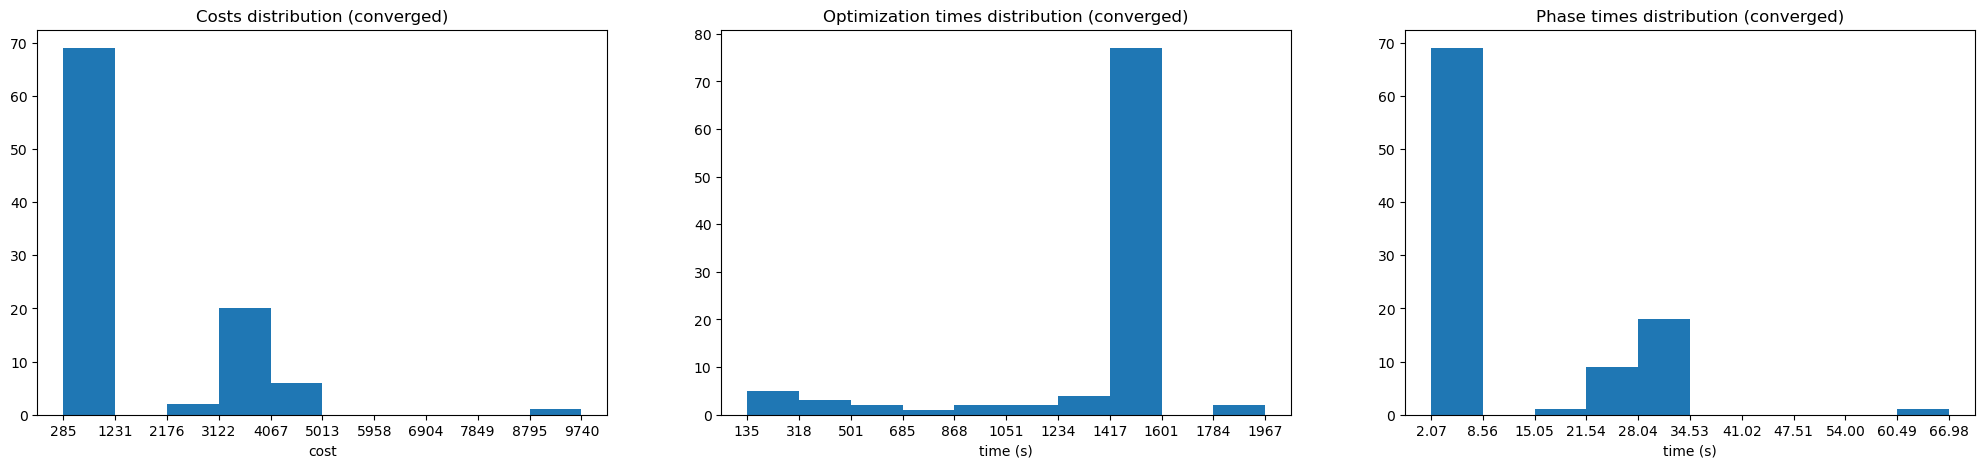

In [15]:
fig, (cax, tax, pax) = plt.subplots(1, 3, figsize=(25, 5))
plot_hist(cax, costs, "Costs distribution (converged)", "cost")
plot_hist(tax, opt_times, "Optimization times distribution (converged)", "time (s)")
plot_hist(pax, phase_times, "Phase times distribution (converged)", "time (s)")

fig.savefig("figures/constraint.pdf")

## Variable first max iterations

In [27]:
init100it = df(type="objective", phase="initial", var="varit", iter=100)
init1000it = df(type="objective", phase="initial", var="varit", iter=1000)
init10000it = df(type="objective", phase="initial", var="varit", iter=10000)
initialvarits = np.array([init100it, init1000it, init10000it])

final100it = df(type="objective", phase="final", var="varit", iter=100)
final1000it = df(type="objective", phase="final", var="varit", iter=1000)
final10000it = df(type="objective", phase="final", var="varit", iter=10000)
finalvarits = np.array([final100it, final1000it, final10000it])

final_convergence_rate = []
final_converged = []
for varit in finalvarits:
    _, converged, convergence = convergence_rate(varit)
    final_convergence_rate.append(convergence)
    final_converged.append(converged)

print("Final convergence rate:", *map(lambda x: f"{x*100:.1f} %", final_convergence_rate))

final_costs = []
final_opt_times = []
final_phase_times = []
for i in range(len(finalvarits)):
    varit = finalvarits[i][final_converged[i]]
    costs, _, _ = analyse(extract_cost, varit)
    opt_times, _, _ = analyse(extract_total_time, varit)
    phase_times, _, _ = analyse(extract_phase_time, varit)
    final_costs.append(costs)
    final_opt_times.append(opt_times)
    final_phase_times.append(phase_times)

initial_convergence_rate = []
for varit in initialvarits:
    _, converged, convergence = convergence_rate(varit)
    initial_convergence_rate.append(convergence)

initial_costs = []
initial_opt_times = []
initial_phase_times = []
for i in range(len(initialvarits)):
    varit = initialvarits[i][final_converged[i]]
    costs, _, _ = analyse(extract_cost, varit)
    opt_times, _, _ = analyse(extract_opt_time, varit)
    phase_times, _, _ = analyse(extract_phase_time, varit)
    initial_costs.append(costs)
    initial_opt_times.append(opt_times)
    initial_phase_times.append(phase_times)

print("Initial convergence rate:", *map(lambda x: f"{x*100:.1f} %", initial_convergence_rate))


Final convergence rate: 93.0 % 98.0 % 98.0 %
Initial convergence rate: 2.0 % 7.0 % 18.0 %


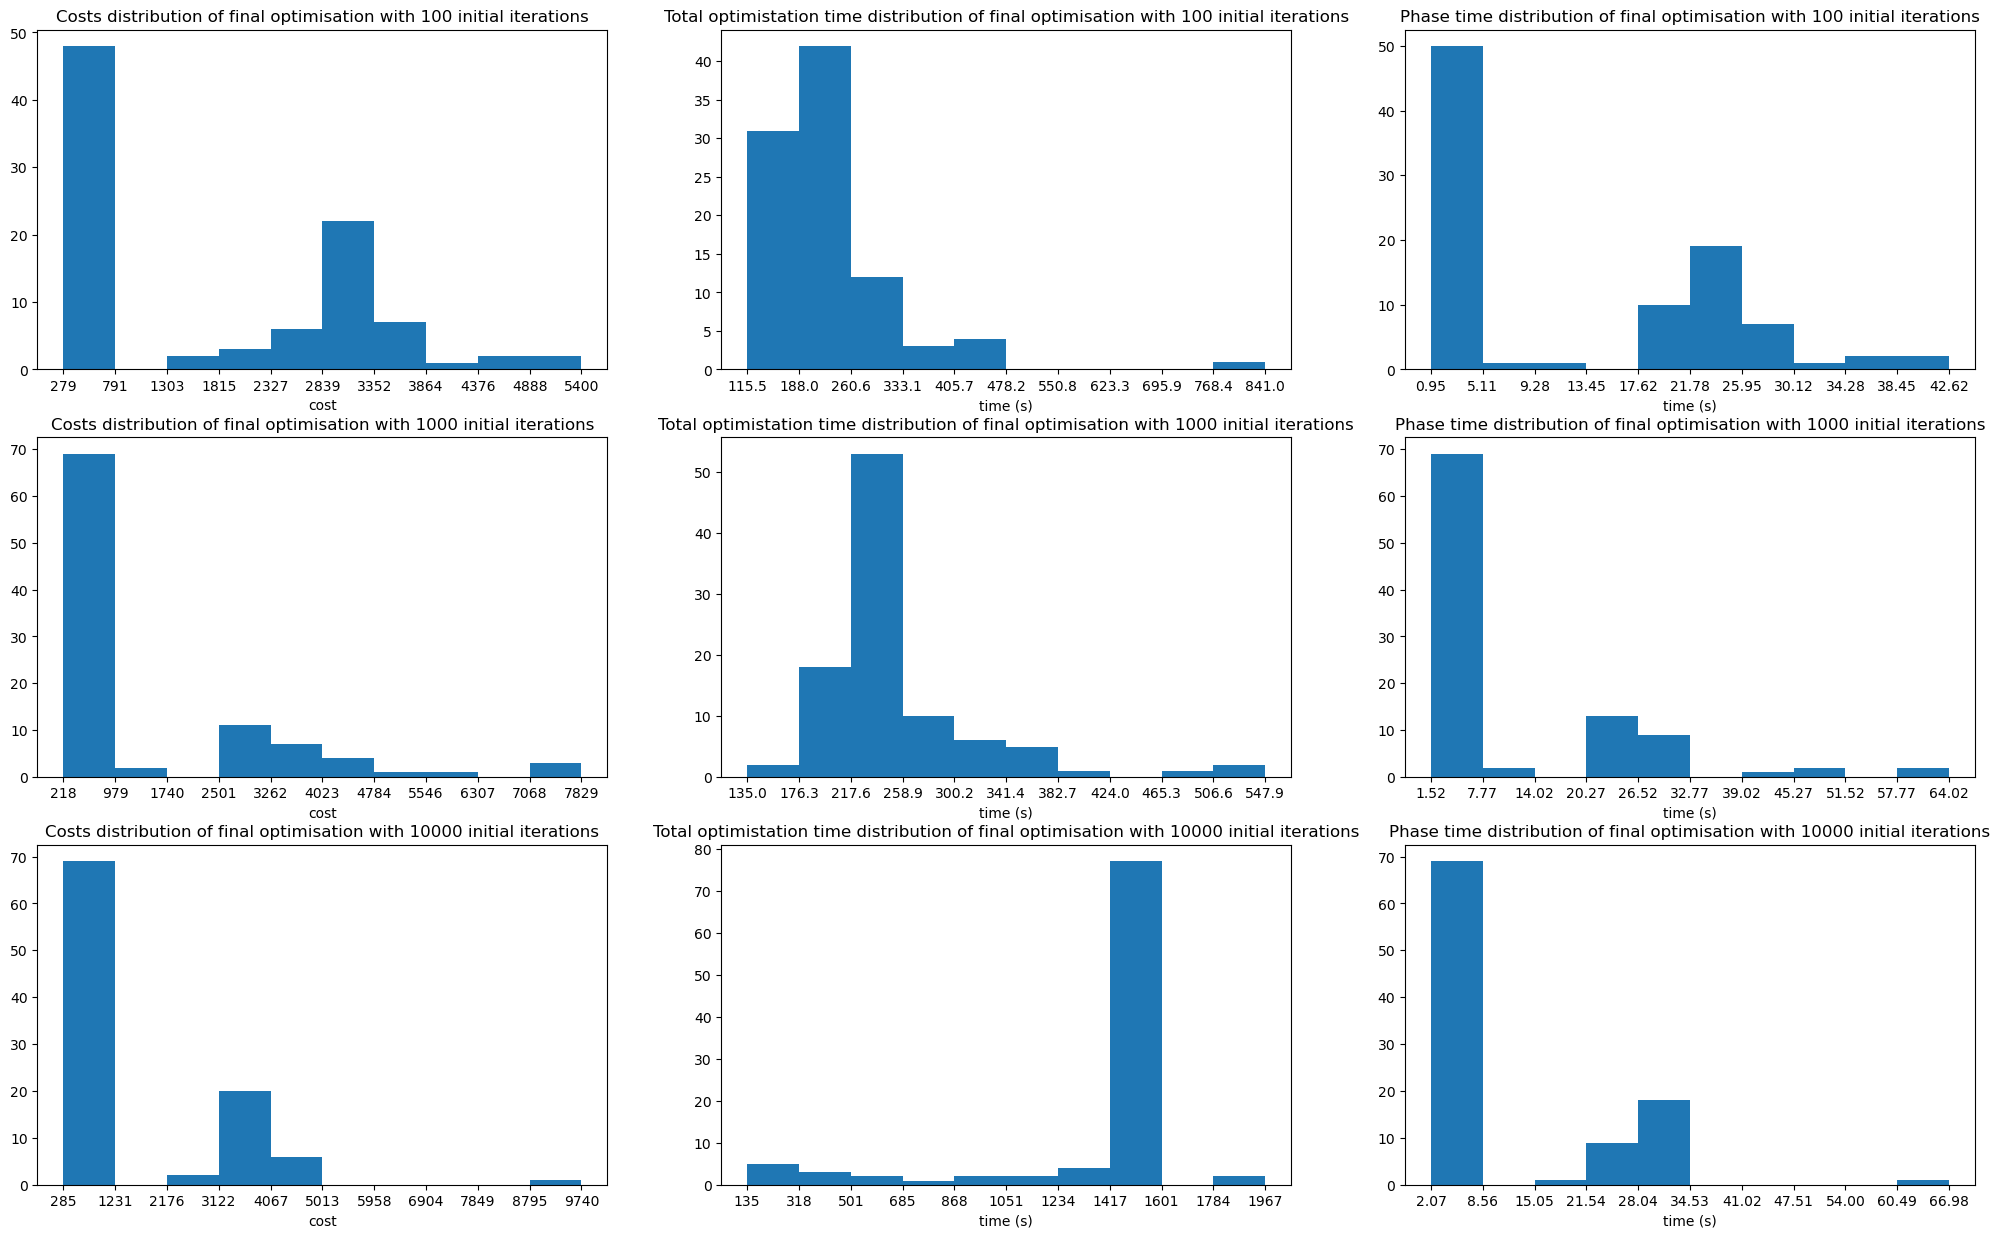

In [30]:
fig, ((cax100, tax100, pax100), (cax1K, tax1K, pax1K), (cax10K, tax10K, pax10K)) = plt.subplots(3, 3, figsize=(25, 15))
plot_hist(cax100, final_costs[0], "Costs distribution of final optimisation with 100 initial iterations", "cost")
plot_hist(cax1K, final_costs[1], "Costs distribution of final optimisation with 1000 initial iterations", "cost")
plot_hist(cax10K, final_costs[2], "Costs distribution of final optimisation with 10000 initial iterations", "cost")

plot_hist(tax100, final_opt_times[0], "Total optimistation time distribution of final optimisation with 100 initial iterations", "time (s)")
plot_hist(tax1K, final_opt_times[1], "Total optimistation time distribution of final optimisation with 1000 initial iterations", "time (s)")
plot_hist(tax10K, final_opt_times[2], "Total optimistation time distribution of final optimisation with 10000 initial iterations", "time (s)")

plot_hist(pax100, final_phase_times[0], "Phase time distribution of final optimisation with 100 initial iterations", "time (s)")
plot_hist(pax1K, final_phase_times[1], "Phase time distribution of final optimisation with 1000 initial iterations", "time (s)")
plot_hist(pax10K, final_phase_times[2], "Phase time distribution of final optimisation with 10000 initial iterations", "time (s)")

fig.savefig("figures/final_varit.pdf")

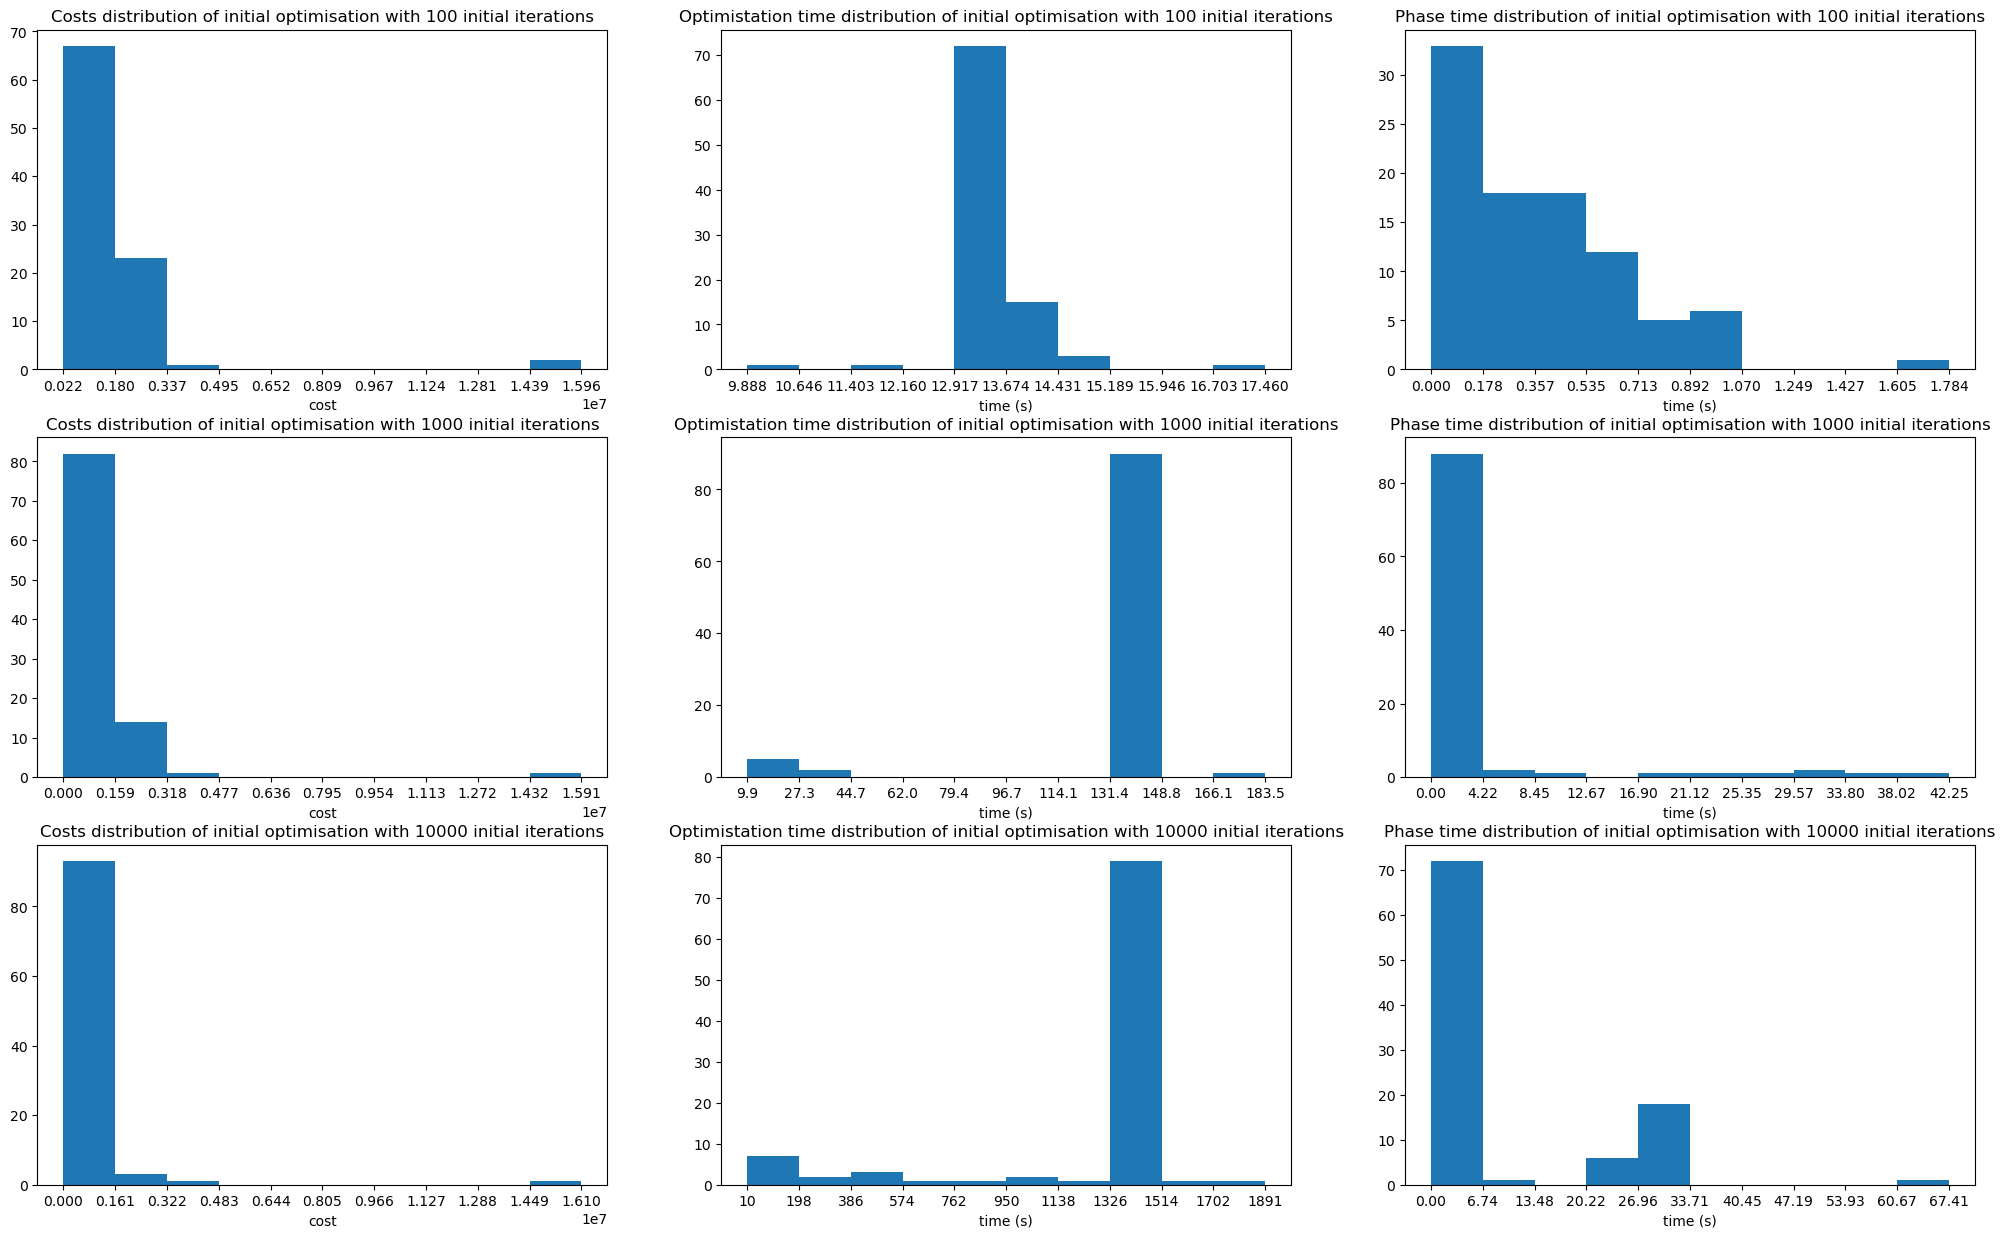

In [31]:
fig, ((cax100, tax100, pax100), (cax1K, tax1K, pax1K), (cax10K, tax10K, pax10K)) = plt.subplots(3, 3, figsize=(25, 15))
plot_hist(cax100, initial_costs[0], "Costs distribution of initial optimisation with 100 initial iterations", "cost")
plot_hist(cax1K, initial_costs[1], "Costs distribution of initial optimisation with 1000 initial iterations", "cost")
plot_hist(cax10K, initial_costs[2], "Costs distribution of initial optimisation with 10000 initial iterations", "cost")

plot_hist(tax100, initial_opt_times[0], "Optimistation time distribution of initial optimisation with 100 initial iterations", "time (s)")
plot_hist(tax1K, initial_opt_times[1], "Optimistation time distribution of initial optimisation with 1000 initial iterations", "time (s)")
plot_hist(tax10K, initial_opt_times[2], "Optimistation time distribution of initial optimisation with 10000 initial iterations", "time (s)")

plot_hist(pax100, initial_phase_times[0], "Phase time distribution of initial optimisation with 100 initial iterations", "time (s)")
plot_hist(pax1K, initial_phase_times[1], "Phase time distribution of initial optimisation with 1000 initial iterations", "time (s)")
plot_hist(pax10K, initial_phase_times[2], "Phase time distribution of initial optimisation with 10000 initial iterations", "time (s)")

fig.savefig("figures/initial_varit.pdf")